##### The GANs are devided into 2 models : 
1. **Generator** : it's the model that generate new samples of the domain, it get vector as input and generate new sample. The vector is choosen from a latent space (that is a projection of data distribution usaly *Gaussian*) 
2. **Descriminator** : it take a sample from the domain (real or generated from the generator) and predict if it's real or fake.

The generator generates a batch of samples, and these, along with real examples from the domain, are provided to the discriminator and classified as real or fake. The discriminator is then updated to get better at discriminating real and fake samples in the next round, and importantly, the generator is updated based on how well, or not, the generated samples fooled the discriminator.

So when the descriminator has good results in the prediction of the new samples (if they real or fake) we don't need to change it's parameters and weights, whereas the parameters of the generator needs to get a large update  

When the generator generate some samples that are perfet and similaire to the real samples, then the descriminator can predict "unsure", this means that it predict 50% for fake  and 50% for real 

GANs works with image data, so they used the CNN for generates new samples and also for the descrimination and the prediction if it's real or fake

An important extension to the GAN is in their use for conditionally generating an output.
The generator and the descriminator can have some additional input

for the training we train the descriminator for a few epochs the we train the generator and we repeat this process

The training of GANs is very difficult and sensitive to the hyperparameters and the activation fonctions, and that because when the Descriminator is good (well trained) so the generator can not generate good images and the inverse is true

In this notebook we are using the MNIST dataset to generate a handwritten images using GANs

## Importing the packages needed

In [1]:
import torch as th 
import torch.nn as nn
import torchvision 
from torchvision.transforms import Normalize, Compose, ToTensor
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import os 
from torch.utils.data import DataLoader
from torchvision.utils import save_image 
from IPython.display import Image

### Loading the data

We are changing the range of the data from [0,1] to [-1,1]

In [2]:
train_mnist = MNIST(
    root="/data",
    train=True, 
    download=True,
    transform= Compose([ToTensor(),Normalize(mean=(0.5,),std=(0.5,))]))

0it [00:00, ?it/s]

Extracting /data/MNIST/raw/train-images-idx3-ubyte.gz to /data/MNIST/raw


0it [00:00, ?it/s]

Extracting /data/MNIST/raw/train-labels-idx1-ubyte.gz to /data/MNIST/raw


0it [00:00, ?it/s]

Extracting /data/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/MNIST/raw


0it [00:00, ?it/s]

Extracting /data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/MNIST/raw
Processing...


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729138878/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


We are now visualising the data before starting to train the GAN

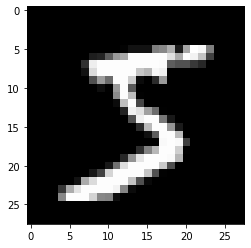

In [15]:
img , label = train_mnist[0]
#creating a fonction that denormalize an image so that we can visualize it. 
def denorm(img):
    img = (img + 1) / 2
    return img.clamp(0,1)
img_denorm = denorm(img)
plt.imshow(img_denorm[0],cmap="gray")
plt.show()


In [3]:
batch_size=  100
train_dl = DataLoader(train_mnist,batch_size,shuffle=True,)

tensor([1, 9, 6, 6, 6, 7, 5, 9, 3, 0, 7, 6, 1, 5, 0, 6, 3, 7, 6, 9, 8, 3, 3, 1,
        7, 8, 8, 4, 4, 9, 1, 8, 7, 3, 4, 0, 9, 9, 4, 1, 9, 9, 2, 7, 3, 3, 7, 9,
        5, 3, 4, 2, 4, 2, 2, 6, 7, 9, 4, 4, 5, 0, 1, 5, 0, 9, 4, 9, 3, 8, 5, 6,
        8, 9, 7, 0, 2, 0, 3, 7, 0, 5, 2, 9, 2, 4, 1, 7, 6, 5, 6, 5, 4, 3, 1, 3,
        5, 4, 8, 2])
torch.Size([100, 1, 28, 28])


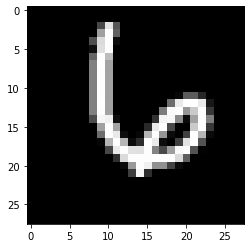

In [6]:
for images,lables in train_dl: 
    print(lables)
    print(images.shape)
    plt.imshow(images[3][0],cmap="gray")
    break
    

In [4]:
# configure our device 
device = th.device("cuda" if th.cuda.is_available() else "cpu")
device

device(type='cuda')

## Discriminator Network 

the discriminator will get an image as input and try to predict if it's real or generated image, for this task we will use 2 solutions: 
1. first we will create a simple feed forward neural network with 3 linear layers and relue activation 
2. second we will use a cnn with 2 conv2d layers and 1 linear layer with the leaky relu activation fonction

The leaky relu is an activation fonction based on ReLU, but it has a small slope for negative values instead of a flat slope, the LeakyReLU instead of setting the negative values to 0 it put a small value based on a slope which get in param
    The leaky-ReLU is popular for tasks like Training GANs 

In [5]:
# we have images of 28x28, we are going to flattened the data to a vector of 784
image_size =  784
hidden_size = 256


In [152]:
Descriminator = nn.Sequential(
    nn.Linear(image_size,hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size,hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size,1),
    nn.Sigmoid()
)
cnn_Descriminator = nn.Sequential(
    nn.Conv2d(1,32,kernel_size=3,stride=2), # 28 * 28 * 1 ==>   13 * 13 * 32
    nn.LeakyReLU(0.2),
    nn.Conv2d(32,64,kernel_size=3,stride=2), # 13 * 13 * 32 == > 6 * 6 * 64 
    nn.LeakyReLU(0.2),
    nn.Flatten(),
    nn.Linear(6 * 6 * 64,1),
    nn.Sigmoid()
)
# cnn_Descriminator.to(device)

As all the binary classification, the output of the descriminator will be a proba of the image being fake or real.

In [153]:
Descriminator.to(device)
cnn_Descriminator.to(device)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
  (1): LeakyReLU(negative_slope=0.2)
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (3): LeakyReLU(negative_slope=0.2)
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=2304, out_features=1, bias=True)
  (6): Sigmoid()
)

## Generator Network

Like the Descriminator, we are going to use first a feedforward with 3 linear layers and another with 2 conv2d layer with leakyReLU fonction activation  

The generator will be a model that has a vector of 64 values as an input and it will output a vector of 784 values, which is the generated image 

As we now, we will give a random vector to the generator, and based on this vector the generator will generate some image, so the dimentions of the vector are called latent_size, and when training the generator this dimentions starts to take some importance and define / identified some feature about the image to generate.

so along the training, the dimentions starts to learn and affects some parts of the generator image

In [205]:
input_size = 64
# for the linear model we are using the ReLU activation fonction 
Gen = nn.Sequential(
    nn.Linear(input_size , hidden_size),
    nn.ReLU(), 
    nn.Linear(hidden_size , hidden_size ), 
    nn.ReLU(),
    nn.Linear(hidden_size , image_size),
    nn.Tanh(),
)
# for the cnn model we are using the LReLU activation fonction 

cnn_Gen = nn.Sequential(
    nn.Conv2d(input_size, 32, kernel_size = 1 ,stride=2),  # 1 * 1 * 64 ==> 1 * 1* 32 
    nn.ReLU(), 
    nn.Conv2d(32 , 512 , kernel_size=1 ,stride=2), # 1 * 1 * 32 ==> 1 * 1* 512 
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(512,image_size),
    nn.Tanh(),
)

We are using the TanH activation fonction that transforms the values in the range of [-1 , 1], that's why we have transforms our real data into that range when loading it.

The reason for using the TanH it's because it gives better results when training it with Generator net

Now that we define the Generator and the Descriminator, we are going to output an image using the Gen and ploting it 

In [206]:
#Defining the input data for the cnn based generator and the linear based gen

input_data_cnn = th.randn(batch_size , input_size,1,1)
print(input_data_cnn.shape)
cnn_output = cnn_Gen(input_data_cnn) 
print(input_data_cnn.shape)
cnn_output  = cnn_output.reshape(-1,28,28)
cnn_gen_image = denorm(cnn_output.detach())

input_data = th.randn(2,input_size)

output = Gen(input_data)
output  = output.reshape(-1,28,28)
gen_image = denorm(output.detach())

# .detach() : tell pytorch to get just the value from a tensor, and detach the tracking of 
# the gradient and the computations associated with this tensor ans alsor with the diffrent operations 
# that are happening to this tensor 

torch.Size([100, 64, 1, 1])
torch.Size([100, 64, 1, 1])


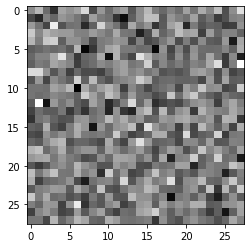

In [207]:
plt.imshow(gen_image[0],cmap="gray")

plotting the image generated from the cnn based Generator


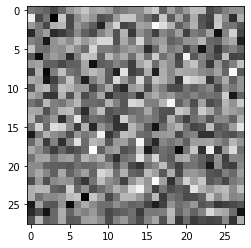

In [208]:
print("plotting the image generated from the cnn based Generator")
plt.imshow(cnn_gen_image[1],cmap="gray")

plotting the image generated from the linear based Generator


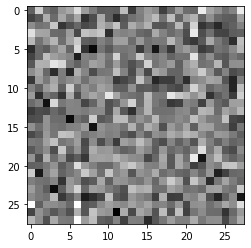

In [209]:
print("plotting the image generated from the linear based Generator")
plt.imshow(gen_image[1],cmap="gray")

we see that the output from the generator is random noise and that because it's not trained yet.

we are going to create a helper fonction that save a batch of output of the models into a file 


In [210]:
Gen.to(device)
cnn_Gen.to(device)

Sequential(
  (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(2, 2))
  (1): ReLU()
  (2): Conv2d(32, 512, kernel_size=(1, 1), stride=(2, 2))
  (3): ReLU()
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=512, out_features=784, bias=True)
  (6): Tanh()
)

## Training the Discriminator

as the descriminator is a binary classifyer so we are going to use the **binary cross entropy loss fonction** to quantify how well is able to deffrencied between real and generated images

In [211]:
criterion = nn .BCELoss()

d_optim = th.optim.Adam(Descriminator.parameters(),lr=0.0002)
cnn_d_optim = th.optim.SGD(cnn_Descriminator.parameters(),lr=0.0001)
g_optim = th.optim.Adam(Gen.parameters(),lr=0.0002)
cnn_g_optim = th.optim.SGD(cnn_Gen.parameters(),lr=0.0001)

 We are going now to create some helper fonctions to reset the gradient and train the descriminator 

In [223]:
 def reset_grad(): 
    d_optim.zero_grad()
    g_optim.zero_grad()
    cnn_d_optim.zero_grad()
    cnn_g_optim.zero_grad()
# noting that in this case we are not interessted in the labels of the data but if it's real of fake

def train_discriminator(images,Des,Gen): 
    # as we are interessted if the images are fake or real so we will define 2 tensors : 
        # one that contains just Ones (many 1) which represent the real images that will be the input for the BCE fonction with the output of the descriminator  
        # the other contains just Zeros (many 0) which represent the fake images that we will give to the BCE when computing the loss of the discriminator after generating some images from the generators 
    real_labels = th.ones(batch_size , 1).to(device)
    fake_labels = th.zeros(batch_size, 1).to(device)
    
    # computing the loss for the real images (when giving just the real images to the descriminator)
    outputs = Des(images)
    # here we expect form the descriminator to output 1 for all the predictions 
    des_loss_real = criterion(outputs, real_labels)
    real_score = outputs
    
    #computing the loss for the fake images that are generated from the Generator 
    inputs = th.randn(batch_size, input_size).to(device)
    fake_images = Gen(inputs)
    outputs = Des(fake_images)
    # here we expect from the descriminator to expect 0 for all the inputs
    des_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs 
    
    # combining the losses 
    d_loss = des_loss_real + des_loss_fake
    # reset the gradient 
    reset_grad()
    # compute the gradient
    d_loss.backward()
    
    # adjust the weights using the backpropagation
    d_optim.step()

    return d_loss , real_score , fake_score , Des


def train_cnn_des(images,Des,Gen):
    fake_labels = th.zeros(batch_size , 1).to(device)
    real_labels = th.ones(batch_size , 1).to(device)
    
    output = Des(images)
    real_loss = criterion(output,real_labels)
    real_score = output
    
    inputs = th.randn(batch_size , input_size,1,1).to(device)
    fake_images = Gen(inputs)
    fake_images= fake_images.reshape(100,1,28,28)
    output = Des(fake_images)
    fake_loss = criterion(output,fake_labels)
    fake_score = output
    
    
    des_loss = real_loss + fake_loss 
    reset_grad()
    des_loss.backward()
    
    cnn_d_optim.step()
    
    
    
    return des_loss, real_score , fake_score, Des
    

## Training the Generator

We are going to use the descriminator for evaluating the predictions of the generator and this by giving the generated images to the descriminator and try to push him to predict that they are real images not fake and use this for computing the loss of the generator.

the core idea is that when passing the generated images into the Descriminator, the outputs needs to be all 1 , so that the generator is perfectly generating the images because the descrimination thaught that they are real images

In [213]:
def train_generator(Des,Gen): 
    #So first we will generate images based on random vectors
    inputs = th.randn(batch_size,input_size).to(device) 
    # inputs for the cnn based generator 
#     cnn_inputs = th.randn(input_size, 2 ,3,3).permute(1,0,2,3)
    fake_images = Gen(inputs)
    # then we are going to create labels for the BCE inputs , the labels will be all ones because 
    # our goal is to pushing the descriminator to predict all 1 (real images)for the generated images
    # so if the outputs of the des are all Ones so our generator work perfectly and the loss needs to be smaller
    labels = th.ones(batch_size, 1).to(device)
    g_loss = criterion(Des(fake_images),labels) #here the generator try to generate images that fools the descriminator
    # so the loss will be smaller if the descriminator predict that all the most of the images are reals
    
    #Backpropagation and optimization
    reset_grad()
    g_loss.backward()
    g_optim.step()
    
    # in the backpropagation we adjust the gen weights (params) in a way that in the next fake images generation
    # the discriminator will be giving values/predictions closer to 1, the fake images will aprear more and more real to the descriminator
    
    
    return g_loss,fake_images,Gen
    
    

def train_cnn_gen(Des,Gen): 
    inputs = th.randn(batch_size , input_size,1,1).to(device)
    fake_images = Gen(inputs)
    labels = th.ones(batch_size , 1).to(device)
    fake_images= fake_images.reshape(100,1,28,28)
    gen_loss = criterion(Des(fake_images), labels)
    reset_grad()
    gen_loss.backward()
    cnn_g_optim.step()
    return gen_loss, fake_images, Gen
    

## Training the Model

In this step , we are going first to create a directory that will helps us to save a version of the output of the generator vor visualize it and analyse the progression of the model 

In [214]:
sample_dir = "./samples_" 
if not os.path.exists(sample_dir): 
    os.makedirs(sample_dir)


In [215]:
#saving a batch of images in the dir so that we can compare the generated images with the real ones 

for images,_ in train_dl : 
    # we can specify to the .save_image() the number of the images that will save, and it create a grid of images ans save it for us 
    save_image(denorm(images),os.path.join(sample_dir,"real_images.png"),nrow=10)
    break



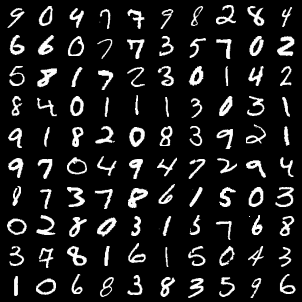

In [216]:
Image(os.path.join(sample_dir,"real_images.png"))

We'll also define a helper fonction for saving some fake images at the end of every epoch and that to see the evolution of the generator , we are going to give the generator a fixed set of random vectors and this to see how each image envolve in time.

saving fake_images_0000.png


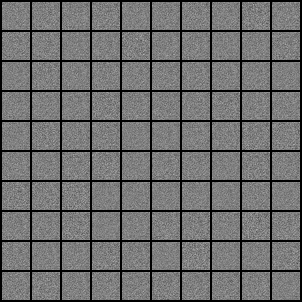

In [217]:
#creating a sample vectors to give them to the generator each epoch, this for observing the evolution #of the fake images generated from the generator.
cnn_sample_vectors = th.randn(batch_size , input_size,1,1).to(device)
sample_vectors =th.randn(batch_size , input_size).to(device)
def save_fake_images(indx,Gen,cnn=False):
    if cnn :         
        generated_images= Gen(cnn_sample_vectors)
        
    else : 
        generated_images= Gen(sample_vectors)

    generated_images = generated_images.reshape(generated_images.size(0),1,28,28)
    fake_file_name = "fake_images_{0:0=4d}.png".format(indx)
    print(f"saving {fake_file_name}")
    save_image(denorm(generated_images),os.path.join(sample_dir,fake_file_name),nrow=10)

indx = 0
save_fake_images(indx,Gen,False)

Image(os.path.join(sample_dir,f"fake_images_000{indx}.png"))

We are ready now to train the model, at each epoch we are going to train the descriminator firs and then the generator 


In [224]:
def train(Des,Gen,epochs,train_dl,cnn=False): 
    des_losses, gen_losses,fake_scores,real_scores  = [], [], [], []
    total_steps = len(train_dl)
    for epoch in range(1,epochs+1):
        # as sad before we are not interessted to use the labels 
        for i ,(images,_) in enumerate(train_dl): 
            # Loading a batch to GPU and transform to vectors 
            images = images.reshape(batch_size,-1).to(device)
            # Train  the descriminator and the generator
            # we must train the descriminator then the generator because we are using the des in the training of the gen 
            if not cnn: 
                
                d_loss, real_score , fake_score, Des  = train_discriminator(images,Des,Gen)
                g_loss , fake_images, Gen = train_generator(Des,Gen)
            else : 
                images = images.reshape(100,1,28,28)
                d_loss , real_score , fake_score , Des = train_cnn_des(images,Des,Gen)
                g_loss , fake_images , Gen = train_cnn_gen(Des,Gen)
            # as we are going to use the cnn based des and gen so we are going to add the logic to train the cnn_gen/des
            
            
        
            
            # inspect the losses at each 200 itteration , remember that there are 600 batch of 100 images each one 
            # so for every 200 batch we will save the losses 
            if (i+1 )%200 == 0:
                # saving the gen and des losses for the 200 batches 
                des_losses.append(d_loss.item())
                gen_losses.append(g_loss.item())
                # noting the the fake/real_scores are the output of the des on fake/real images 
                # so we are saving the avrg propability of the des for the real and fake images
                fake_scores.append(fake_score.mean().item())
                real_scores.append(real_score.mean().item())
                print(f"Epoch : {epoch}/{epochs} Step : {i+1} / {total_steps} d_loss : {round(d_loss.item(),3)} g_loss : {round(g_loss.item(),3)} D(x) : {round(real_score.mean().item(),3)} D(G(input)) : {round(fake_score.mean().item(),3)}")
                
                
                
        # saving the fake images for visualisation
        save_fake_images(epoch,Gen,cnn=cnn)
    return des_losses, gen_losses,fake_scores,real_scores , Des,Gen
            

In [228]:
%%time
EPOCHS = 100
des_losses, gen_losses,fake_scores,real_scores , Descriminator,Gen  = train(Descriminator,Gen,EPOCHS,train_dl)

Epoch : 1/10 Step : 200 / 600 d_loss : 0.231 g_loss : 3.83 D(x) : 0.915 D(G(input)) : 0.062
Epoch : 1/10 Step : 400 / 600 d_loss : 0.241 g_loss : 3.211 D(x) : 0.941 D(G(input)) : 0.125
Epoch : 1/10 Step : 600 / 600 d_loss : 0.192 g_loss : 3.881 D(x) : 0.919 D(G(input)) : 0.06
saving fake_images_0001.png
Epoch : 2/10 Step : 200 / 600 d_loss : 0.413 g_loss : 4.301 D(x) : 0.86 D(G(input)) : 0.107
Epoch : 2/10 Step : 400 / 600 d_loss : 0.288 g_loss : 3.188 D(x) : 0.923 D(G(input)) : 0.136
Epoch : 2/10 Step : 600 / 600 d_loss : 0.48 g_loss : 2.474 D(x) : 0.857 D(G(input)) : 0.172
saving fake_images_0002.png
Epoch : 3/10 Step : 200 / 600 d_loss : 0.277 g_loss : 3.489 D(x) : 0.895 D(G(input)) : 0.092
Epoch : 3/10 Step : 400 / 600 d_loss : 0.055 g_loss : 4.399 D(x) : 0.99 D(G(input)) : 0.034
Epoch : 3/10 Step : 600 / 600 d_loss : 0.105 g_loss : 4.548 D(x) : 0.964 D(G(input)) : 0.046
saving fake_images_0003.png
Epoch : 4/10 Step : 200 / 600 d_loss : 0.16 g_loss : 5.703 D(x) : 0.949 D(G(input)) 

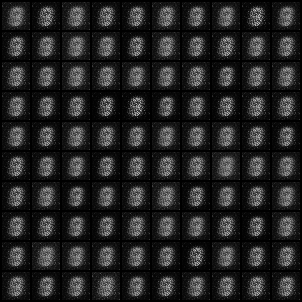

In [229]:
Image(os.path.join(sample_dir,f"fake_images_0001.png"))

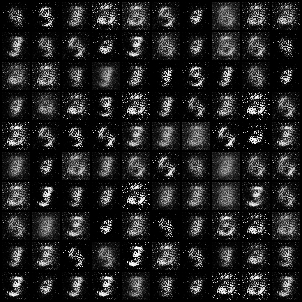

In [230]:
Image(os.path.join(sample_dir,f"fake_images_0008.png"))

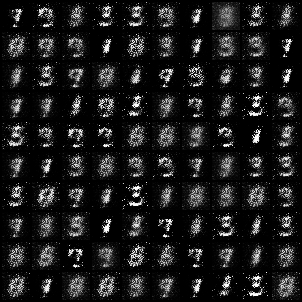

In [231]:
Image(os.path.join(sample_dir,f"fake_images_0010.png"))

In [ ]:
# Image(os.path.join(sample_dir,f"fake_images_100.png"))


## Saving the Model

In [ ]:
th.save(Gen.state_dict(),"Gen.ckpt")
th.save(Descriminator.state_dict(),"Des.ckpt")

## Visualizing the results

For visualizing the evolution of the model we are going to create a video based on the fake images that we saved earlier, and that using OpenCv

We are getting a video that contains the evolutions of the images generated by the generator while traing 

In [43]:
import cv2
from IPython.display import FileLink

video_file_name = 'Gan_Train_evol.avi'
# loading all the savec images 
files = [os.path.join(sample_dir,f) for f in os.listdir(sample_dir) if "fake_images" in f]
files.sort()
# now we have all the files are sorted and saved in the files var 
# next we are going to combine them into 1 video using the cv2.VideoWriter() fonction 
out = cv2.VideoWriter(video_file_name,cv2.VideoWriter_fourcc(*"MP4V"),8,(302,302))
# 4 param : Frame per second
[out.write(cv2.imread(file_name)) for file_name in files]
out.release()
FileLink(video_file_name)


/kaggle/working/Gan_Train_evol.avi

## Visualizing the losses and scores

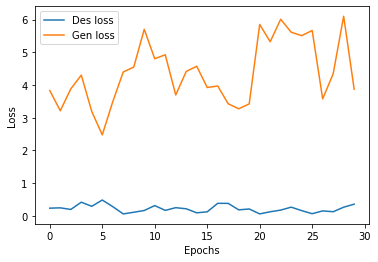

In [232]:
plt.plot(des_losses)
plt.plot(gen_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Des loss","Gen loss"])

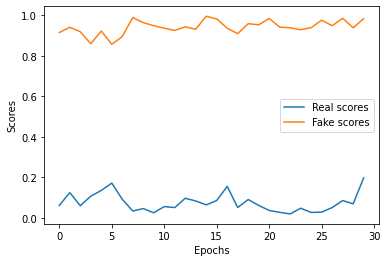

In [233]:
plt.plot(fake_scores)
plt.plot(real_scores)
plt.xlabel("Epochs")
plt.ylabel("Scores")
plt.legend(["Real scores","Fake scores"])

## Using the CNN based Descriminator and Generator 

After observing the results that gives us the Linear based Descriminator and Generator, we are going now to use the CNN based models and train them.

In [234]:
%%time
EPOCHS = 300
cnn_des_losses, cnn_gen_losses,cnn_fake_scores,cnn_real_scores , cnn_Descriminator,cnn_Gen  = train(cnn_Descriminator,cnn_Gen,EPOCHS,train_dl,cnn=True)

Epoch : 1/30 Step : 200 / 600 d_loss : 0.031 g_loss : 3.846 D(x) : 0.991 D(G(input)) : 0.022
Epoch : 1/30 Step : 400 / 600 d_loss : 0.027 g_loss : 3.852 D(x) : 0.995 D(G(input)) : 0.021
Epoch : 1/30 Step : 600 / 600 d_loss : 0.027 g_loss : 3.872 D(x) : 0.994 D(G(input)) : 0.021
saving fake_images_0001.png
Epoch : 2/30 Step : 200 / 600 d_loss : 0.028 g_loss : 3.875 D(x) : 0.993 D(G(input)) : 0.02
Epoch : 2/30 Step : 400 / 600 d_loss : 0.027 g_loss : 3.895 D(x) : 0.994 D(G(input)) : 0.02
Epoch : 2/30 Step : 600 / 600 d_loss : 0.029 g_loss : 3.897 D(x) : 0.992 D(G(input)) : 0.02
saving fake_images_0002.png
Epoch : 3/30 Step : 200 / 600 d_loss : 0.025 g_loss : 3.893 D(x) : 0.995 D(G(input)) : 0.02
Epoch : 3/30 Step : 400 / 600 d_loss : 0.028 g_loss : 3.932 D(x) : 0.994 D(G(input)) : 0.021
Epoch : 3/30 Step : 600 / 600 d_loss : 0.026 g_loss : 3.894 D(x) : 0.994 D(G(input)) : 0.02
saving fake_images_0003.png
Epoch : 4/30 Step : 200 / 600 d_loss : 0.027 g_loss : 3.918 D(x) : 0.993 D(G(input))

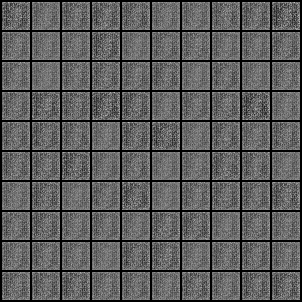

In [239]:
Image(os.path.join(sample_dir,f"fake_images_0010.png"))

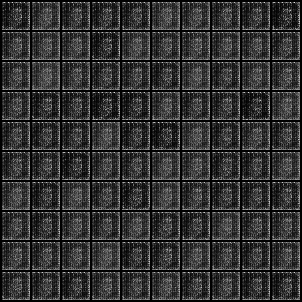

In [240]:
Image(os.path.join(sample_dir,f"fake_images_0020.png"))

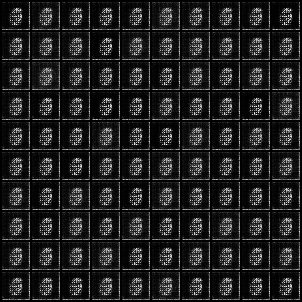

In [241]:
Image(os.path.join(sample_dir,f"fake_images_0030.png"))

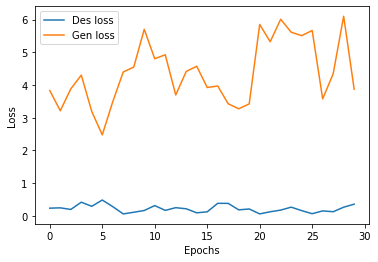

In [242]:
plt.plot(des_losses)
plt.plot(gen_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Des loss","Gen loss"])


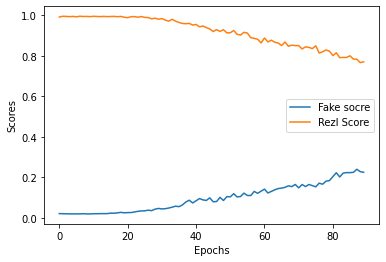

In [244]:
plt.plot(cnn_fake_scores)
plt.plot(cnn_real_scores)
plt.xlabel("Epochs")
plt.ylabel("Scores")
plt.legend(["Fake socre","Rezl Score"])
